# IMAGINE tutorial 1

### TestField + LiSimulator + Multinest

in this tutorial, we focus on introducing the basic building blocks in IMAGINE package and how to use them for assembling a Bayesian analysis pipeline

- the target field in play is designed to vaively mimic Faraday depth, which is affected linearly by (Galactic) magnetic field

$ field(x) = cos(x) * \mathcal{G}(mean=a,std=b;seed=s) $, $x \in (0,2\pi)$

where $\{a,b\}$ is the 'physical' parameter set, $s$ represents the seed for random variable generation

- first of all we need to prepare mock data, which should contain the signal field and a noise field

- with mock data and its (co)variance matrix, we shall assemble IMAGINE pipeline and execute for results

In [1]:
%matplotlib inline

import numpy as np
import logging as log

from imagine.observables.observable_dict import Simulations, Measurements, Covariances
from imagine.likelihoods.ensemble_likelihood import EnsembleLikelihood
from imagine.fields.test_field.test_field_factory import TestFieldFactory
from imagine.priors.flat_prior import FlatPrior
from imagine.simulators.test.li_simulator import LiSimulator
from imagine.pipelines.multinest_pipeline import MultinestPipeline
from imagine.tools.covariance_estimator import oas_cov

# visualize posterior
import corner
import matplotlib
from imagine.tools.carrier_mapper import unity_mapper
matplotlib.use('Agg')

## step 1, mock data preparation

the basic logic in mock data preparation reads

$ data(x) = signal(x) + noise(x) $

for simplicity, we propose a gaussian noise

$ noise(x) = \mathcal{G}(mean=0,std=e) $ whose seed is irrelevant

In [2]:
a0 = 3. # true value of a
b0 = 6. # true value of b
e = 0.1 # std of gaussian measurement error
s = 233 # seed fixed for signal field

size = 10 # data size in measurements
x = np.linspace(0,2.*np.pi,size) # where the observer is looking at

np.random.seed(s) # set seed for signal field

signal = np.multiply (np.cos(x), np.random.normal(loc=a0,scale=b0,size=size))

data = np.vstack([signal + np.random.normal(loc=0.,scale=e,size=size)]) # vstack will be explained later

cov = (e**2) * np.eye(size) # pre-defined according to measurement error

IMAGINE will not take raw data assembled above directly

the reason is this: there will be many data coming at the same time, with various formats and sizes

IMAGINE has to register different data by name, format, size, etc., in order to trigger simulator efficiently

so, we designed **ObservableDict** class for help

**ObservableDict** class is build upon class **Observable** which is supported by **NIFTy5** at the backend

as it is named, **ObservableDict** hosts a dictionary for **Observable** objects which host fields or ensemble of fields

as you may have realized, **ObservableDict** is not only convenient for hosting data, but also available to outputs from simulators

so under this base class, come three children 

**Measurements** class for observational/measured data sets

**Simulations** class for simulated outputs

**Covariances** class for observational/measured data covariance matrices

data and/or covariance matrix should be firstly formed in either numpy ndarray type or NIFTy Field type

a tag should be applied to each data/matrix piece, with convention:

**( 'name', 'observed frequency in GHz', 'size or HEALPix Nside', 'extra tag' )** 

i.e., a WMAP 23GHz STOKES Q map with Nside 128 may have a dictionary entry ('wmap','23','128','Q')

another example, a plain test map with size 56 may have a dictionary entry ('test','nan','56','nan')

there, if no frequency or extra tag is necessary fill the blanck with 'nan'

to collect data/matrix, use **append** function as illustrated below, notice that if a plain data is about to be 

appended, set plain=True since the default argument is for HEALPix map with 'Nside' in its entry

In [3]:
mock_data = Measurements() # create empty Measrurements object
mock_data.append(('test', 'nan', str(size), 'nan'), data, True)

mock_cov = Covariances() # create empty Covariance object
mock_cov.append(('test', 'nan', str(size), 'nan'), cov, True)

there is a reason we use numpy vstack in the very beginning

in IMAGINE we decide not to explicitly use numpy vector with shape (data size, )

instead we force the convention to be (ensemble size, data size)

now if you are familiar to NIFTy5, it is straight forwad in knowing retriving raw data from above

nevertheless, we show it here, in **Observable** class we aligned the to_global_data the same as which in NIFTy5

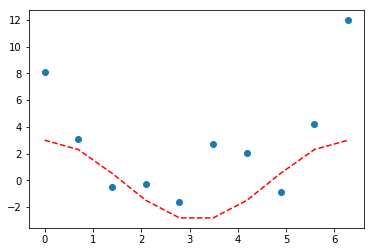

In [4]:
matplotlib.pyplot.scatter(x, mock_data[('test', 'nan', str(size), 'nan')].to_global_data()[0])
matplotlib.pyplot.plot(x,np.cos(x)*a0,'r--')

## step 2, pipeline assembling

after mock data, there are several steps to the final pipeline:

we need to know likelihood and priors, field models and simulators

let's do field models and simulators first

simulators are merely python interfaces to external libraries, i.e., hammurabi X

there will be cases where users want to bind several external libraries together

for that we suggest users to assemble there own interface, rather than use several existed simulator interfaces

it will become clear when you see field and factry classes

for physical fields, we propose **GeneralFieldFactory** and **GeneralField** classes as templates

factory classes will be directly invoked in pipeline, in order to generate field objects

field objects once being generated, will be hand in to simulators for producing observables

the reason for seperately defining factories and fields lies in the fact that

in each random walk of Bayesian analysis, we update active parameters in fields and unmistakably send them to simulators

factories are like 'factories', users have to define active parameters and whose varying ranges

updating field instant parameter values is also done in factories

fields, on the other hand, does nothing but informs simulators the latest parameter values and where to find them

so a particularily assembled simulator may very likely be different from others

especially in where and how parameters are registered

we recommend XML format for all simulators

yep, neither fields nor factories contain the actual method for GENERATING field scalars/vectors

we though it is not necessary to do so (at least currently) as simulators will take care of that

In [5]:
factory = TestFieldFactory(active_parameters=('a','b')) # factory with single active parameter
factory.parameter_ranges = {'a':(0,10),'b':(0,10)} # adjust parameter range for Bayesian analysis
factory_list = [factory] # a list of factories is required by pipeline

simer = LiSimulator(mock_data) # simulator needs to know what observables it should provide

now comes the priors and likelihoods

IMAGINE provides **Likelihood** class with **EnsembleLikelihood** and **SimpleLikelihood** as two working children

we do not have space to introduce how log-likelihoods are calculated here

likelihood initialization requires measurements, this is at the front end 

while driving it requires simulated outputs, this is prisoned inside pipelines at the back end

it is considered that in many cases, not all data sets are accompanied by covarainces

**Likelihood** is flexible about that so no worries

what to do if there is not a single covariance matrix?

users can initialize likelihood object with data only (**Measurements** object)

In [6]:
prior = FlatPrior()

likelihood = EnsembleLikelihood(mock_data, mock_cov) # initialize likelihood with measured info

Yeah, the pipeline at last!

as you will see below, **Pipeline** class takes all above stuff to take off

basice input arguments are presented

sure, there are tons of controlling parameters associated to Bayesian samplers

for that, users have to dig into documentations of samplers and our source code

we have a few instructions there

anyway, we provide **MultinestPipeline** and **DynestyPipeline**

**Multinest** or **pyMultinest** is quite old but fast, as its core in Fortran

**Dynesty** is new and purely in Python, extremely well documented, but it's slooooow, well not too slow

interestingly, Dynesty and pyMultinest share similar frontend so no big trouble in shifting

read and paly with the examples then you will understand

In [7]:
ensemble_size = 100
pipe = MultinestPipeline(simer, factory_list, likelihood, prior, ensemble_size)
pipe.random_seed = 0 # favor fixed seed? try a positive integer
pipe.sampling_controllers = {'n_iter_before_update': 1,
                             'n_live_points': 400,
                             'verbose': False,
                             'resume': False}

## roll out

IMAGINE pipeline use variable cubes with range $[0,1]$ as it is

converting from variables to parameters are automatically done in factories

for visualizing results we need a bit detour but easy

  analysing data from /tmp/tmpfw3czi_9pymultinest/.txt


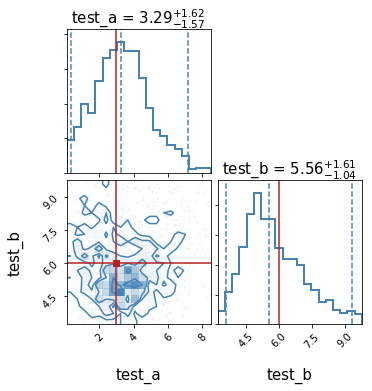

In [8]:
results = pipe()

samples = results['samples']  # load sample points

for i in range(len(pipe.active_parameters)): # convert variables into parameters
    low, high = pipe.active_ranges[pipe.active_parameters[i]]
    for j in range(samples.shape[0]):
        samples[j,i] = unity_mapper(samples[j,i],low,high)

# corner plot
figure = corner.corner(samples[:, :len(pipe.active_parameters)],
                       range=[0.99]*len(pipe.active_parameters),
                       quantiles=[0.02, 0.5, 0.98],
                       labels=pipe.active_parameters,
                       show_titles=True,
                       title_kwargs={"fontsize": 15},
                       color='steelblue',
                       truths=[a0,b0],
                       truth_color='firebrick',
                       plot_contours=True,
                       hist_kwargs={'linewidth': 2},
                       label_kwargs={'fontsize': 15})

## roll again

as mentioned above, IMAGINE also interfaces Dyesty

the only difference at frontend is the sampler-dependent controlling parameters

iter: 1733+400 | bound: 5 | nc: 1 | ncall: 17689 | eff(%): 12.058 | loglstar:   -inf < -24.523 <    inf | logz: -27.980 +/-  0.083 | dlogz:  0.001 >  0.409            

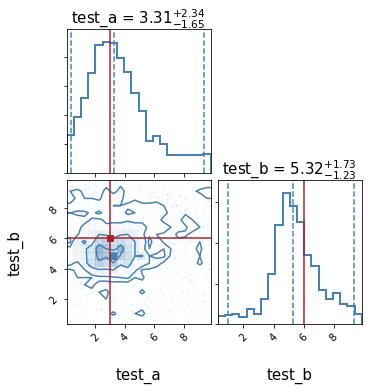

In [9]:
from imagine.pipelines.dynesty_pipeline import DynestyPipeline

pipe = DynestyPipeline(simer, factory_list, likelihood, prior, ensemble_size)
pipe.random_seed = 0
pipe.sampling_controllers = {'nlive': 400} # mind the difference here

results = pipe()
samples = results['samples']
for i in range(len(pipe.active_parameters)):
    low, high = pipe.active_ranges[pipe.active_parameters[i]]
    for j in range(samples.shape[0]):
        samples[j, i] = unity_mapper(samples[j, i], low, high)
# corner plot
figure = corner.corner(samples[:, :len(pipe.active_parameters)],
                       range=[0.99]*len(pipe.active_parameters),
                       quantiles=[0.02, 0.5, 0.98],
                       labels=pipe.active_parameters,
                       show_titles=True,
                       title_kwargs={"fontsize": 15},
                       color='steelblue',
                       truths=[a0,b0],
                       truth_color='firebrick',
                       plot_contours=True,
                       hist_kwargs={'linewidth': 2},
                       label_kwargs={'fontsize': 15})

## convergence check

as mock data was generated with fixed random seed

while in Bayesian analysis time-thread dependent seeds are adopted

it is interesting to check if different executions are consistent

iter: 1782+400 | bound: 6 | nc: 1 | ncall: 18676 | eff(%): 11.683 | loglstar:   -inf < -24.404 <    inf | logz: -28.000 +/-  0.082 | dlogz:  0.001 >  0.409            

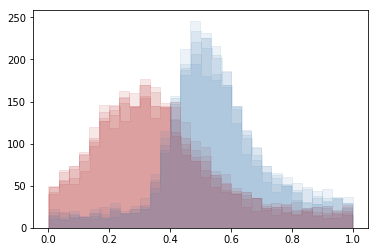

In [10]:
from scipy.stats import norm
repeat = 5

for i in range(repeat):
    tmp = pipe()
    asamp = tmp['samples'][:,0]
    bsamp = tmp['samples'][:,1]
    matplotlib.pyplot.hist(asamp,30,histtype='step',stacked=True,fill=True,color='firebrick',alpha=0.1)
    matplotlib.pyplot.hist(bsamp,30,histtype='step',stacked=True,fill=True,label='b',color='steelblue',alpha=0.1)

### now you are prepared, for more examples in imagine/examples directory